In [2]:
# Install Kaggle
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Mount ke Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Setup folder
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

 41% 9.00M/21.8M [00:00<00:00, 16.4MB/s]
100% 21.8M/21.8M [00:00<00:00, 33.9MB/s]


In [6]:
os.mkdir("satelliteimage")

In [7]:
import shutil

In [8]:
# Unzip dataset
shutil.unpack_archive("satellite-image-classification.zip", "/content/satelliteimage")

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [10]:
dir = "/content/satelliteimage/data"

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.20
)

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.20)

In [14]:
train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode="categorical", # default
    subset="training"
)

Found 4505 images belonging to 4 classes.


In [15]:
validation_generator = test_datagen.flow_from_directory(
    dir,
    target_size=(150, 150),
    batch_size=4,
    class_mode="categorical", # default
    subset="validation"
)

Found 1126 images belonging to 4 classes.


In [16]:
classes = len(os.listdir(dir))
classes

4

In [89]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input
import tensorflow as tf

In [102]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(150, 150, 3)),
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(classes, activation='softmax')
])

In [103]:
model.layers[0].trainable = False

In [104]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 conv2d_91 (Conv2D)          (None, 3, 3, 16)          294928    
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 1, 1, 16)         0         
 ng2D)                                                           
                                                                 
 dense_138 (Dense)           (None, 1, 1, 512)         8704      
                                                                 
 dropout_106 (Dropout)       (None, 1, 1, 512)         0         
                                                                 
 dense_139 (Dense)           (None, 1, 1, 512)         262656    
                                                     

In [105]:
# compile model dengan 'adam' optimizer loss function 'categorical_crossentropy' 
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [106]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.92 and logs.get('val_accuracy') >0.92:
      print("\nAkurasi telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [107]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=5,
      callbacks=[callbacks],
      verbose=2)

Epoch 1/30
100/100 - 17s - loss: 1.0827 - accuracy: 0.4650 - val_loss: 0.9975 - val_accuracy: 0.6000 - 17s/epoch - 168ms/step
Epoch 2/30
100/100 - 4s - loss: 0.9482 - accuracy: 0.6350 - val_loss: 0.3832 - val_accuracy: 0.7500 - 4s/epoch - 41ms/step
Epoch 3/30
100/100 - 4s - loss: 0.6175 - accuracy: 0.7053 - val_loss: 0.7631 - val_accuracy: 0.7000 - 4s/epoch - 41ms/step
Epoch 4/30
100/100 - 4s - loss: 0.6308 - accuracy: 0.7150 - val_loss: 0.5523 - val_accuracy: 0.6500 - 4s/epoch - 40ms/step
Epoch 5/30
100/100 - 5s - loss: 0.6518 - accuracy: 0.7575 - val_loss: 0.2348 - val_accuracy: 0.8500 - 5s/epoch - 50ms/step
Epoch 6/30
100/100 - 4s - loss: 0.4936 - accuracy: 0.7632 - val_loss: 0.5120 - val_accuracy: 0.8500 - 4s/epoch - 40ms/step
Epoch 7/30
100/100 - 4s - loss: 0.5424 - accuracy: 0.8475 - val_loss: 0.1499 - val_accuracy: 0.9000 - 4s/epoch - 40ms/step
Epoch 8/30
100/100 - 4s - loss: 0.3204 - accuracy: 0.9025 - val_loss: 1.5197 - val_accuracy: 0.7500 - 4s/epoch - 40ms/step
Epoch 9/30
10

Text(0.5, 1.0, 'Loss training dan validation')

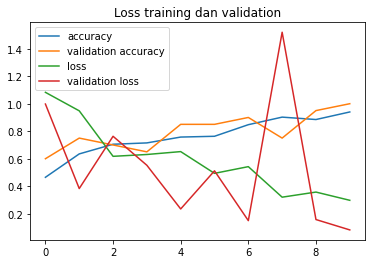

In [108]:
# Evaluasi Hasil

# Accuracy dan validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss dan validation
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Accuracy & validation plot
plt.plot(epochs, acc, label="accuracy")
plt.plot(epochs, val_acc, label="validation accuracy")
plt.title('Akurasi Training dan Validation')
plt.legend(loc="upper left")

# Loss & validation plot
plt.plot(epochs, loss, label="loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.legend(loc="upper left")
plt.title('Loss training dan validation')

In [109]:
import pathlib

In [110]:
# Menyimpan model dalam format SavedModel
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [35]:
# Convert SavedModel menjadi satelliteimageclassification.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [111]:
tflite_model_file = pathlib.Path('satelliteimage.tflite')
tflite_model_file.write_bytes(tflite_model)

338200108